In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import scipy, sqlite3, h5py

import pandas as pd

import sklearn
import sklearn.model_selection as model_selection
from sklearn.preprocessing import StandardScaler

import rampy as rp

import sys
sys.path.append("/home/charles/GoogleDrive/viscopy/")
sys.path.append("/home/charles/GoogleDrive/structupy/")
import viscopy as vp
import structupy as spy

In [2]:
def pretreatment(dataset,split_valid,split_test,output_file, rand_state=81):

    print('Reading data...')
    # reading the Pandas dataframe
    dataset = vp.chimie_control(dataset)
    ap, b = vp.heatcp(dataset,Cp_glass = "3R") # Cp coeffs
    n_b_o = spy.nbot(dataset) # NBO/T
    ionicfs = spy.ifs(dataset) # IFS of metals

    dataset['ap'] = ap
    dataset['b'] = b
    dataset['nbot'] = n_b_o['nbot']
    dataset['ifsm'] = ionicfs['ifsm']
    dataset['ifst'] = ionicfs['ifst']#.fillna(0.0)

    # train-valid-test split
    print("Splitting datasets...\n")
    tv_sub, test_sub, idxtv_sub, idxtest_sub = rp.chemical_splitting(dataset,'Name',split_fraction=split_test, rand_state=rand_state)
    train_sub, valid_sub, idxtrain_sub, idxvalid_sub = rp.chemical_splitting(tv_sub,'Name',split_fraction=split_valid, rand_state=rand_state)

    # For entropy dataset
    train_entropy = train_sub.dropna(subset=['Sc'])
    valid_entropy = valid_sub.dropna(subset=['Sc'])
    test_entropy = test_sub.dropna(subset=['Sc'])

    # Now we need to fillna in other datasets
    train_sub = train_sub.fillna(0.0)
    valid_sub = valid_sub.fillna(0.0)
    test_sub = test_sub.fillna(0.0)

    # Viscosity train-valid-test splits
    y_train = train_sub["viscosity"].values.reshape(-1,1)
    y_valid = valid_sub["viscosity"].values.reshape(-1,1)
    y_tv = tv_sub["viscosity"].values.reshape(-1,1)
    y_test = test_sub["viscosity"].values.reshape(-1,1)

    # FOR KNAS : CHOICE
    X_columns = ["sio2","al2o3","na2o","k2o","nbot","ifsm","ifst","ap","b","T","Sc","tg"]
    
    X_train = train_sub.loc[:,X_columns].values
    X_valid = valid_sub.loc[:,X_columns].values
    X_tv = tv_sub.loc[:,X_columns].values
    X_test = test_sub.loc[:,X_columns].values

    X_entropy_train = train_entropy.loc[:,X_columns].values
    X_entropy_valid = valid_entropy.loc[:,X_columns].values
    X_entropy_test = test_entropy.loc[:,X_columns].values

    print("X training and validation set shape, unscaled")
    print(X_train.shape)
    #print(X_train_sc.shape)

    print("X valid set shape, unscaled")
    print(X_valid.shape)
    #print(X_valid_sc.shape)

    print("X test set shape, unscaled")
    print(X_test.shape)
    #print(X_test_sc.shape)

    print("\nEntropy training shape, unscaled")
    print(train_entropy.shape)

    print("Entropy validation shape, unscaled")
    print(valid_entropy.shape)

    print("Entropy testing shape, unscaled")
    print(test_entropy.shape)

    print("... Scaling ...")
    # scaling
    X_scaler = StandardScaler().fit(X_train)
    Y_scaler = StandardScaler().fit(y_train)

    X_entropy_train_sc = X_scaler.transform(X_entropy_train)
    X_entropy_valid_sc = X_scaler.transform(X_entropy_valid)
    X_entropy_test_sc = X_scaler.transform(X_entropy_test)

    X_tv_sc = X_scaler.transform(X_tv)

    X_train_sc = X_scaler.transform(X_train)
    y_train_sc = Y_scaler.transform(y_train.reshape(-1,1))

    X_valid_sc = X_scaler.transform(X_valid)
    y_valid_sc = Y_scaler.transform(y_valid.reshape(-1,1))

    X_test_sc = X_scaler.transform(X_test)
    y_test_sc = Y_scaler.transform(y_test.reshape(-1,1))

    # we ensure that only the chemistry was standardized
    X_train_sc[:,7:] = X_train[:,7:]
    X_valid_sc[:,7:] = X_valid[:,7:]
    X_test_sc[:,7:] = X_test[:,7:]
    X_tv_sc[:,7:] = X_tv[:,7:]

    X_entropy_train_sc[:,7:] = X_entropy_train[:,7:]
    X_entropy_valid_sc[:,7:] = X_entropy_valid[:,7:]
    X_entropy_test_sc[:,7:] = X_entropy_test[:,7:]

    print("... Scaled.")

    # Figure of the datasets
    plt.figure()
    plt.subplot(121)
    plt.plot(10000/X_train[:,9],y_train,"k.")

    plt.subplot(121)
    plt.plot(10000/X_valid[:,9],y_valid,"b.")

    plt.subplot(121)
    plt.plot(10000/X_test[:,9],y_test,"r.")
    plt.show()

    print("Size of viscous training subsets:\n")
    print(X_train.shape)
    
    # writing the data in HDF5 file for later call
    with h5py.File(output_file, 'w') as f:
        f.create_dataset('X_columns', data=np.array(X_columns, dtype="S10"))

        f.create_dataset('X_entropy_train', data=X_entropy_train)
        f.create_dataset('X_entropy_train_sc', data=X_entropy_train_sc)

        f.create_dataset('X_entropy_valid', data=X_entropy_valid)
        f.create_dataset('X_entropy_valid_sc', data=X_entropy_valid_sc)

        f.create_dataset('X_entropy_test', data=X_entropy_test)
        f.create_dataset('X_entropy_test_sc', data=X_entropy_test_sc)

        f.create_dataset('X_tv', data=X_tv)
        f.create_dataset('X_tv_sc', data=X_tv_sc)
        f.create_dataset('y_tv', data=y_tv)

        f.create_dataset('X_train', data=X_train)
        f.create_dataset('X_train_sc', data=X_train_sc)

        f.create_dataset('y_train', data=y_train)
        f.create_dataset('y_train_sc', data=y_train_sc)

        f.create_dataset('X_valid', data=X_valid)
        f.create_dataset('X_valid_sc', data=X_valid_sc)

        f.create_dataset('y_valid', data=y_valid)
        f.create_dataset('y_valid_sc', data=y_valid_sc)

        f.create_dataset('X_test', data=X_test)
        f.create_dataset('X_test_sc', data=X_test_sc)

        f.create_dataset('y_test', data=y_test)
        f.create_dataset('y_test_sc', data=y_test_sc)

        f.create_dataset('X_scaler_mean', data=X_scaler.mean_)
        f.create_dataset('X_scaler_var', data=X_scaler.var_)

        f.create_dataset('y_scaler_mean', data=Y_scaler.mean_)
        f.create_dataset('y_scaler_var', data=Y_scaler.var_)



Index(['Name', 'sio2', 'al2o3', 'fe2o3', 'h2o', 'na2o', 'k2o', 'mgo', 'cao',
       'feo', 'tg', 'T', 'viscosity', 'ref', 'color', 'Sc'],
      dtype='object')
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(1065, 12)
X valid set shape, unscaled
(88, 12)
X test set shape, unscaled
(250, 12)

Entropy training shape, unscaled
(536, 27)
Entropy validation shape, unscaled
(36, 27)
Entropy testing shape, unscaled
(124, 27)
... Scaling ...
... Scaled.


/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


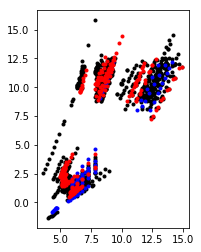

Size of viscous training subsets:

(1065, 12)
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(964, 12)
X valid set shape, unscaled
(189, 12)
X test set shape, unscaled
(250, 12)

Entropy training shape, unscaled
(483, 27)
Entropy validation shape, unscaled
(89, 27)
Entropy testing shape, unscaled
(124, 27)
... Scaling ...
... Scaled.


/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


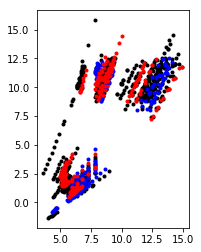

Size of viscous training subsets:

(964, 12)
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(868, 12)
X valid set shape, unscaled
(285, 12)
X test set shape, unscaled
(250, 12)

Entropy training shape, unscaled
(427, 27)
Entropy validation shape, unscaled
(145, 27)
Entropy testing shape, unscaled
(124, 27)
... Scaling ...
... Scaled.


/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


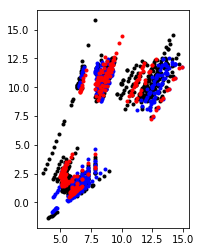

Size of viscous training subsets:

(868, 12)
Reading data...
Splitting datasets...



/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


X training and validation set shape, unscaled
(717, 12)
X valid set shape, unscaled
(436, 12)
X test set shape, unscaled
(250, 12)

Entropy training shape, unscaled
(351, 27)
Entropy validation shape, unscaled
(221, 27)
Entropy testing shape, unscaled
(124, 27)
... Scaling ...
... Scaled.


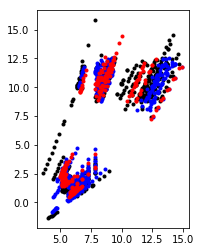

Size of viscous training subsets:

(717, 12)
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(593, 12)
X valid set shape, unscaled
(560, 12)
X test set shape, unscaled
(250, 12)

Entropy training shape, unscaled
(312, 27)
Entropy validation shape, unscaled
(260, 27)
Entropy testing shape, unscaled
(124, 27)
... Scaling ...
... Scaled.


/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


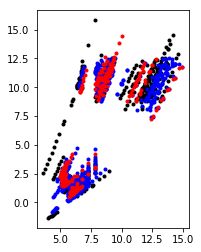

Size of viscous training subsets:

(593, 12)
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(480, 12)
X valid set shape, unscaled
(673, 12)
X test set shape, unscaled
(250, 12)

Entropy training shape, unscaled
(246, 27)
Entropy validation shape, unscaled
(326, 27)
Entropy testing shape, unscaled
(124, 27)
... Scaling ...
... Scaled.


/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


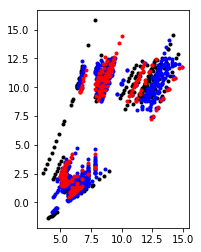

Size of viscous training subsets:

(480, 12)
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(337, 12)
X valid set shape, unscaled
(816, 12)
X test set shape, unscaled
(250, 12)

Entropy training shape, unscaled
(158, 27)
Entropy validation shape, unscaled
(414, 27)
Entropy testing shape, unscaled
(124, 27)
... Scaling ...
... Scaled.


/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


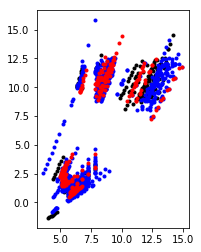

Size of viscous training subsets:

(337, 12)
Reading data...
Splitting datasets...

X training and validation set shape, unscaled
(209, 12)
X valid set shape, unscaled
(944, 12)
X test set shape, unscaled
(250, 12)

Entropy training shape, unscaled
(110, 27)
Entropy validation shape, unscaled
(462, 27)
Entropy testing shape, unscaled
(124, 27)
... Scaling ...
... Scaled.


/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


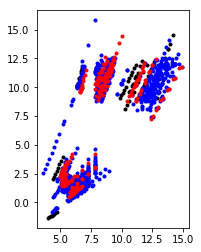

Size of viscous training subsets:

(209, 12)


In [3]:
# KNAS, comment to deactivate
dataset = pd.read_excel("./data/Database_IPGP.xlsx")
print(dataset.columns)

fractions_valid = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80]
prefix= ["_0p10val","_0p20val","_0p30val","_0p40val","_0p50val","_0p60val","_0p70val","_0p80val"]
fraction_test = 0.15

for indice,value in enumerate(fractions_valid):
    pretreatment(dataset,value,fraction_test,"./data/DataSet"+prefix[indice]+".hdf5", rand_state=81)

# Density preparation

In [8]:
dataset = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="DENSITY")
dataset.head()

def prepare_density(dataset,output_file):
    
    # Import data
    X_d = dataset.loc[:, ["sio2","al2o3","na2o","k2o"]]/100.0
    y_d = dataset.loc[:, ["d"]]
    
    # train-test split
    X_tv, X_test, y_tv, y_test = model_selection.train_test_split(X_d, y_d, test_size=0.30, random_state=42)
    X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_tv, y_tv, test_size=0.15, random_state=42)

    # writing the data in HDF5 file for later call
    with h5py.File(output_file, 'w') as f:
        f.create_dataset('X_density_train', data=X_train)
        f.create_dataset('X_density_valid', data=X_valid)
        f.create_dataset('X_density_test',  data=X_test)

        f.create_dataset('y_density_train', data=y_train)
        f.create_dataset('y_density_valid', data=y_valid)
        f.create_dataset('y_density_test',  data=y_test)
        
    print("Done.")
        
prepare_density(dataset,"./data/NKAS_density.hdf5")

Done.
